# Carregar as bibliotecas

In [3]:
import numpy as np
import pandas as pd
from skimage import io, data, filters, util, color, transform, exposure, measure, feature
from skimage.util import img_as_float, img_as_uint, img_as_ubyte
import matplotlib.pyplot as plt
from sklearn import preprocessing, metrics, svm
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [4]:
# blblioteca para arquivos zipados
import zipfile
# biblioteca para tranalhar com arquivos
import os

### Download do arquivo numbers.zip

In [5]:
!gdown 1g7sA9bPWYOKRcTew88EDV_mdxR0j1rl4

Downloading...
From: https://drive.google.com/uc?id=1g7sA9bPWYOKRcTew88EDV_mdxR0j1rl4
To: /content/numbers.zip
100% 15.1k/15.1k [00:00<00:00, 40.9MB/s]


### Descomprimir arquivo zip

In [6]:
local_zip = 'numbers.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('tmp')
zip_ref.close()

In [7]:
m_path = 'tmp/numbers'
img_files = os.listdir(m_path)
print(img_files)

['num5.jpg', 'num0.jpg', 'num9.jpg', 'num7.jpg', 'num2.jpg', 'num4.jpg', 'num3.jpg', 'num1.jpg', 'num8.jpg', 'num6.jpg']


### Ordena alfabeticamente os nomes dos arquivos

In [8]:
img_files.sort()
print(img_files)

['num0.jpg', 'num1.jpg', 'num2.jpg', 'num3.jpg', 'num4.jpg', 'num5.jpg', 'num6.jpg', 'num7.jpg', 'num8.jpg', 'num9.jpg']


# Questão 1

<p align="justify">O reconhecimento de padrões é o estudo de como as máquinas observam seu entorno, aprendem a distinguir padrões de interesse e tomam decisões razoáveis sobre as categorias dos padrões Um padrão é uma descrição de um objeto. Um computador consegue reconhecer padrões, convertendo-os em sinais digitais e comparando-os com outros sinais já armazenados na memória.  </p>

<p align="justify">
Um sistema de reconhecimento geralmente compreende três componentes principais: pré-processamento, extração de características e classificação. Na etapa de pré-processamento, os dados de entrada são manipulados por uma variedade de métodos que fazem operações, tais como remoção de ruído, segmentação e melhoramento da qualidade dos mesmos. Na extração de características, o objetivo é representar os dados de entrada em termos de medidas quantificáveis que possam ser utilizados facilmente na etapa de classificação. O problema do reconhecimento de padrões é reconhecer padrões que sejam, em algum
sentido, "os mesmos" apesar de ter experimentado uma variedade de transformações permitidas. Os padrões na vida real apresentam transformações geométricas lineares (rotação, escala e translação), deformações não lineares e variância de iluminação e <i>background</i>, etc. Este tipo de reconhecimento pode ser uma tarefa simples para os seres humanos e para os animais, mas converte-se em um grande problema se tentamos realizá-lo através de um computador. Os métodos tradicionais de reconhecimento de padrões carecem da habilidade para reconhecer o mesmo padrão com certo tipo de variância.</p>

<p align="justify">
Execute os seguintes pasos para cada imagem da base de dados:
</p>

<ol>
    <li>Para cada inagem fornecida, gere 20 imagens com diferentes rotações</li>
    <li>Cada imagem rotacionado deve ser redimensionada em seis diferentes escalas: 0.5, 0.75, 1, 1.25, 1.5, 2</li>
    <li>Inserir ruído tipo sal e pimenta en cada imagem redimensionada. Use os seguintes valores de rúido: 0, 0.01, 0.02, 0.03</li>
    <li>Extrair os momentos de Hu de cada imagem e salvar o descritor em uma matriz e a etiqueta a qual pertence em um vetor.</li>

</ol>







In [9]:
def Hu_moments(img):
  momentos_centrais = measure.moments_central(img)
  momentos_normalizados = measure.moments_normalized(momentos_centrais)
  momentos_hu = measure.moments_hu(momentos_normalizados)
  return momentos_hu

<p align="justify">  Função <i>feature_extraction()</i> extrai as características de todas as imagens e salva em uma matriz os vetores de caractarísticas. Não é necessário salvar as imagens, crie a imagem e logo faça a extração de características. </p>

In [10]:
def feature_extraction(m_path, img_files):
    angs = np.linspace(0, 180, 20)
    tams = [0.5, 0.75, 1, 1.25, 1.5, 2]
    ruidos = [0, 0.01, 0.02, 0.03]

    N = len(img_files) * len(angs) * len(tams) * len(ruidos)
    hu_X = np.zeros((N, 7)) # Matriz dos descritores
    hu_Y = np.zeros((N)) # Vetor de etiquetas/labels
    pos = 0

    for l, file in enumerate(img_files):
        img = io.imread(os.path.join(m_path, file), as_gray=True)
        print(f"Processando {file}")
        for ang in angs:
            rimg = transform.rotate(img, angle=ang)
            for tam in tams:
                simg = transform.rescale(rimg, (tam, tam))
                for ruido in ruidos:
                    nimg = util.random_noise(simg, mode='s&p', amount=ruido)
                    #nimg = img_as_ubyte(nimg)
                    humom = Hu_moments(nimg)
                    hu_X[pos, :] = humom
                    hu_Y[pos] = l
                    pos += 1
    return hu_X, hu_Y

In [11]:
hu_X, hu_Y = feature_extraction(m_path='tmp/numbers', img_files = img_files)

Processando num0.jpg
Processando num1.jpg
Processando num2.jpg
Processando num3.jpg
Processando num4.jpg
Processando num5.jpg
Processando num6.jpg
Processando num7.jpg
Processando num8.jpg
Processando num9.jpg


### 5. Normalizar os dados

<p>O objetivo da normalização é alterar os valores das colunas numéricas no conjunto de dados para uma escala comum, sem distorcer as diferenças nos intervalos de valores.</p>

* Normalização
$$X_{new} = \frac{ X - X_{min} }{ X_{max} - X_{min} }$$

<p>
class <b>sklearn.preprocessing.MinMaxScaler</b>(feature_range=(0, 1),  copy=True, clip=False)
<ul>
    <li>feature_range: tuple (min, max), default=(0, 1). Desired range of transformed data.</li>
    <li>copy: bool, default=True. Set to False to perform inplace row normalization and avoid a copy (if the input is already a numpy array).</li>
    <li>clip: bool, default=False. Set to True to clip transformed values of held-out data to provided feature range.</li>
</ul>
</p>

* Padronização
<p>
$$X_{changed} = \frac{ X - \mu }{ \sigma } $$
Importando o módulo de preprocessamento</p>

<p>
class <b>sklearn.preprocessing.StandardScaler</b>(copy=True, with_mean=True, with_std=True
<ul>
    <licopy: bool: default=True. If False, try to avoid a copy and do inplace scaling instead. This is not guaranteed to always work inplace; e.g. if the data is not a NumPy array or scipy.sparse CSR matrix, a copy may still be returned.</li>
    <li>with_mean: bool, default=True. If True, center the data before scaling. This does not work (and will raise an exception) when attempted on sparse matrices, because centering them entails building a dense matrix which in common use cases is likely to be too large to fit in memory.</li>
    <li>with_std: bool, default=True. If True, scale the data to unit variance (or equivalently, unit standard deviation).</li>
</ul>
</p>

In [12]:
# TESTAR SOMENTE UM METODO PARA O PROCESSO TODO(normalizar ou padronizar, não ambos ao mesmo tempo)

# normalização
#X_new = preprocessing.MinMaxScaler().fit_transform(X)
#minmax_scaler = preprocessing.MinMaxScaler().fit(hu_X)
#hu_Xn = minmax_scaler.transform(hu_X)

# padronização
std_scaler = preprocessing.StandardScaler().fit(hu_X)
hu_Xp = std_scaler.transform(hu_X)

### 6. Dividir o conjunto de dados en treino e teste
<p>
<b>sklearn.model_selection.train_test_split</b>(*arrays, test_size=None, train_size=None, random_state=None, shuffle=True, stratify=None)
<ul>
    <li>*arrays: sequence of indexables with same length / shape[0]. Allowed inputs are lists, numpy arrays, scipy-sparse matrices or pandas dataframes.</li>
    <li>test_size: float or int, default=None. If float, should be between 0.0 and 1.0 and represent the proportion of the dataset to include in the test split. If int, represents the absolute number of test samples. If None, the value is set to the complement of the train size. If train_size is also None, it will be set to 0.25.</li>
    <li>train_size: float or int, default=None. If float, should be between 0.0 and 1.0 and represent the proportion of the dataset to include in the train split. If int, represents the absolute number of train samples. If None, the value is automatically set to the complement of the test size.</li>
    <li>random_state: int, RandomState instance or None, default=None. Controls the shuffling applied to the data before applying the split. Pass an int for reproducible output across multiple function calls. See Glossary.</li>
    <li>shuffle: bool, default=True. Whether or not to shuffle the data before splitting. If shuffle=False then stratify must be None.</li>
    <li>stratify: array-like, default=None. If not None, data is split in a stratified fashion, using this as the class labels.</li>
</ul>
Returns
<ul>
    <li>splitting: list, length=2 * len(arrays). List containing train-test split of inputs.</li>
</ul>
</p>














In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    hu_Xp, hu_Y, test_size=0.2)

### 7. Instanciar o modelo SVM e treinar

<p>
<b>class sklearn.svm.SVCt</b>(*, C=1.0, kernel='rbf', degree=3, gamma='scale', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape='ovr', break_ties=False, random_state=None)
<ul>
    <li>C: float, default=1.0. Regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive. The penalty is a squared l2 penalty.</li>
    <li>kernel: {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’} or callable, default=’rbf’. Specifies the kernel type to be used in the algorithm. If none is given, ‘rbf’ will be used. If a callable is given it is used to pre-compute the kernel matrix from data matrices; that matrix should be an array of shape (n_samples, n_samples).</li>
    <li>degree: int, default=3. Degree of the polynomial kernel function (‘poly’). Must be non-negative. Ignored by all other kernels.</li>
    <li>gamma: {‘scale’, ‘auto’} or float, default=’scale’. Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.</li>
    <li>coef0: float, default=0.0. Independent term in kernel function. It is only significant in ‘poly’ and ‘sigmoid’.</li>
    <li>shrinkingbool, default=True. Whether to use the shrinking heuristic.</li>
    <li>probabilitybool, default=False. Whether to enable probability estimates. This must be enabled prior to calling fit, will slow down that method as it internally uses 5-fold cross-validation, and predict_proba may be inconsistent with predict.</li>
    <li>tol: float, default=1e-3. Tolerance for stopping criterion.</li>
    <li>cache_size: float, default=200. Specify the size of the kernel cache (in MB).</li>
    <li>class_weight: dict or ‘balanced’, default=None. Set the parameter C of class i to class_weight[i]*C for SVC. If not given, all classes are supposed to have weight one. The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y)).</li>
    <li>verbose: bool, default=False. Enable verbose output. Note that this setting takes advantage of a per-process runtime setting in libsvm that, if enabled, may not work properly in a multithreaded context.</li>
    <li>max_iterint, default=-1. Hard limit on iterations within solver, or -1 for no limit.</li>
    <li>random_state: int, RandomState instance or None, default=None. Controls the pseudo random number generation for shuffling the data for probability estimates. Ignored when probability is False. Pass an int for reproducible output across multiple function calls.</li>
</ul>
</p>

## Métodos
<p>
<ul>
  <li><b>fit</b>: The fit method is provided on every estimator. It usually takes some samples X, targets y if the model is supervised, and potentially other sample properties such as sample_weight. It should:</li>
    <ul>
    <li>clear any prior attributes stored on the estimator, unless warm_start is used;</li>
    <li>validate and interpret any parameters, ideally raising an error if invalid;</li>
    <li>validate the input data;</li>
    <li>estimate and store model attributes from the estimated parameters and provided data; and</li>
    <li>return the now fitted estimator to facilitate method chaining.</li>
    </ul>
  <li>predict: Makes a prediction for each sample, usually only taking X as input (but see under regressor output conventions below). In a classifier or regressor, this prediction is in the same target space used in fitting (e.g. one of {‘red’, ‘amber’, ‘green’} if the y in fitting consisted of these strings). Despite this, even when y passed to fit is a list or other array-like, the output of predict should always be an array or sparse matrix. In a clusterer or outlier detector the prediction is an integer.

If the estimator was not already fitted, calling this method should raise a exceptions.NotFittedError.

Output conventions:
    <ul>
    <li>classifier: An array of shape (n_samples,) (n_samples, n_outputs). Multilabel data may be represented as a sparse matrix if a sparse matrix was used in fitting. Each element should be one of the values in the classifier’s classes_ attribute.</li>
    <li>clusterer: An array of shape (n_samples,) where each value is from 0 to n_clusters - 1 if the corresponding sample is clustered, and -1 if the sample is not clustered, as in cluster.dbscan.</li>
    <li>outlier detector: An array of shape (n_samples,) where each value is -1 for an outlier and 1 otherwise.</li>
    <li>regressor: A numeric array of shape (n_samples,), usually float64. Some regressors have extra options in their predict method, allowing them to return standard deviation (return_std=True) or covariance (return_cov=True) relative to the predicted value. In this case, the return value is a tuple of arrays corresponding to (prediction mean, std, cov) as required.</li>
    </ul>
</ul>
</p>
























In [14]:
clf_svm = svm.SVC(C=5, kernel='linear')
clf_svm.fit(X_train, y_train)
pred = clf_svm.predict(X_test)

## 8. Calcular a matriz de confusão

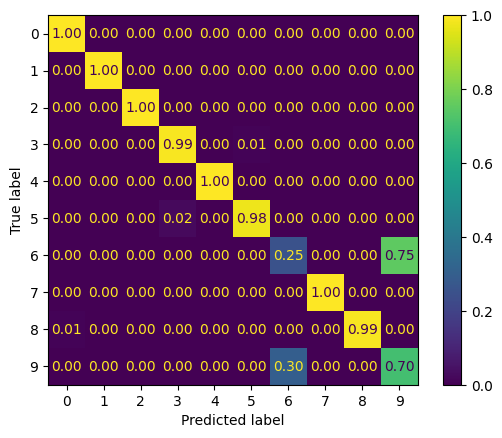

In [15]:
matriz =  metrics.confusion_matrix(y_test, pred)
tot = np.sum(matriz, axis=1, keepdims=True)
np.set_printoptions(precision=2)
m_porc = matriz/tot
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=m_porc, display_labels=[0,1,2,3,4,5,6,7,8,9])
disp.plot(values_format='.2f')
plt.show()

# Questão 1.2

<p>Avaliar o modelo treinado reconhecendo os números na seguinte imagem:</p>

<img src="https://drive.google.com/uc?id=1iewo9yp9i_S-AXAvkdJA0LzUeKZNJGi7" alt="Drawing"  width="700"/> </td>

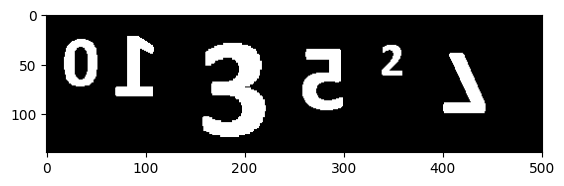

In [16]:
img = io.imread('https://drive.google.com/uc?id=1iewo9yp9i_S-AXAvkdJA0LzUeKZNJGi7', as_gray=True)
img = img > 0.5
plt.imshow(img, cmap='gray')

<p align="justify">O seguinte código gera os <i>bounding box</i> ao redor de cada número</p>

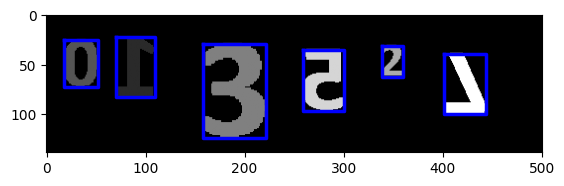

In [17]:
img_label = measure.label(img)
regions = measure.regionprops(img_label)
fig, ax = plt.subplots()
ax.imshow(img_label, cmap=plt.cm.gray)
for props in regions:
    minr, minc, maxr, maxc = props.bbox
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    ax.plot(bx, by, '-b', linewidth=2.5)

### Reconheça da um dos caracteres usando o modelo treinado

In [18]:
print(len(regions))

6


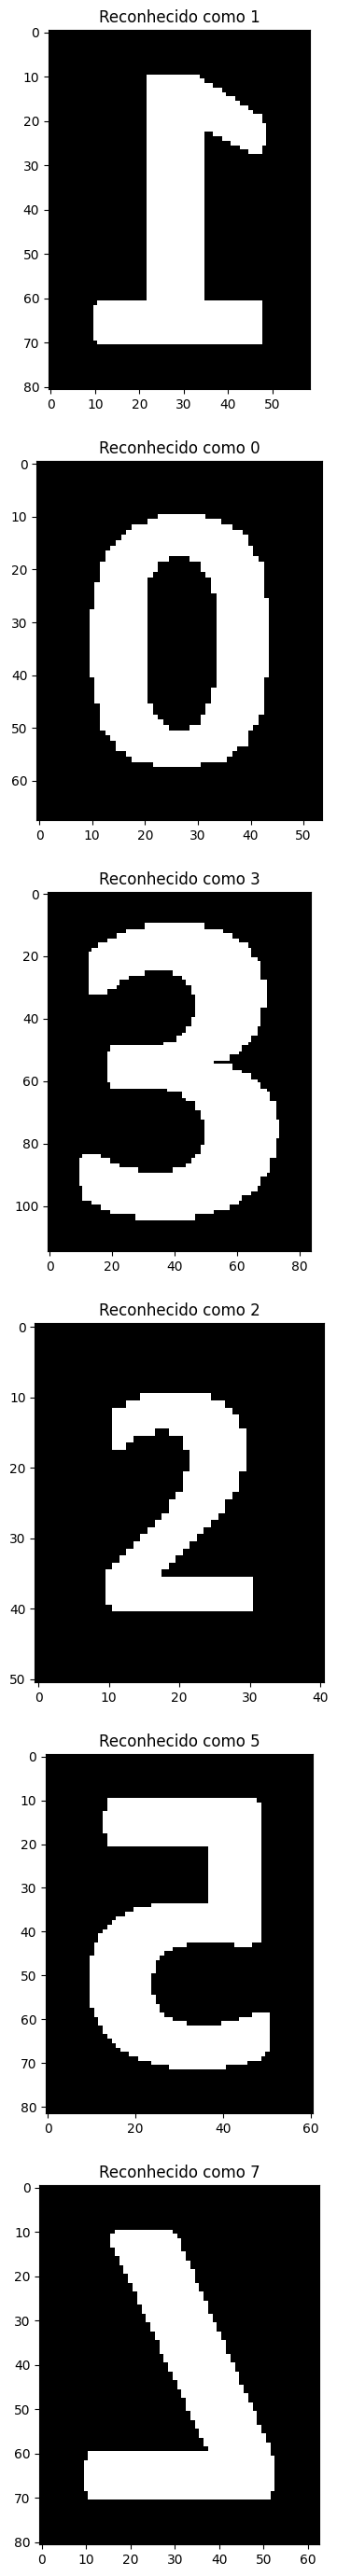

In [19]:
n = len(regions)
f, ax = plt.subplots(n, 1, figsize=(10, 10 + 5 * (n - 1)))
for i, props in enumerate(regions):
    minr, minc, maxr, maxc = props.bbox
    delta = 10
    minr = max(minr - delta, 0)
    minc = max(minc - delta, 0)
    maxr = min(maxr + delta, img.shape[0])
    maxc = min(maxc + delta, img.shape[1])
    patch = img[minr:maxr, minc:maxc]

    ax[i].imshow(patch, cmap='gray')

    # Preenchimentos solicitados:
    humom = Hu_moments(patch)          # extrair os momentos de Hu de cada patch
    hu_Xp = std_scaler.transform([humom])                     # normalizar ou padronizar
    pred = clf_svm.predict(hu_Xp)                       # predizer

    ax[i].set_title(f'Reconhecido como {int(pred[0])}')

## Questão 2

## Leitura da bas MNIST em formato csv

<p>A base de dados MNIST (base de dados do Instituto Nacional Modificado de Padrões e Tecnologia) é uma coleção amplamente utilizada de dígitos manuscritos, comumente empregada para treinar e testar sistemas de processamento de imagens e modelos de aprendizado de máquina.</p>

<img src="https://datasets.activeloop.ai/wp-content/uploads/2019/12/MNIST-handwritten-digits-dataset-visualized-by-Activeloop.webp" />

<p>
O conjunto de dados original está em um formato que pode ser desafiador para iniciantes. Este dataset, criado com o trabalho de Joseph Redmon, fornece a base MNIST em formato CSV, disponível no <a href="https://www.kaggle.com/datasets/oddrationale/mnist-in-csv">Kaggle</a></p>

<p>
O conjunto de dados está dividido em dois arquivos:
 <ol>
 <li>mnist_train.csv</li>
 <li>mnist_test.csv</li>
 </ol>
<p>

<p>
O arquivo <i>mnist_train.csv</i> contém 60.000 exemplos de treinamento, enquanto o <i>mnist_test.csv</i> contém 10.000 exemplos de teste. Cada linha desses arquivos é composta por 785 valores: o primeiro valor é o rótulo (um número de 0 a 9) e os 784 valores restantes correspondem aos valores de pixel (números entre 0 e 255). A imagem bidimensional de $28 \times 28$ pixels é reorganizada em um vetor unidimensional de $1 \times 784$, onde cada linha da matriz representa uma imagem distinta.</p>


In [20]:
# download do treino
!gdown 1QsPU-7UkrI2JH_MUv99RNdnOhGxUIlPb

Downloading...
From (original): https://drive.google.com/uc?id=1QsPU-7UkrI2JH_MUv99RNdnOhGxUIlPb
From (redirected): https://drive.google.com/uc?id=1QsPU-7UkrI2JH_MUv99RNdnOhGxUIlPb&confirm=t&uuid=8f8556a9-d352-42a6-9365-f6a95fab9e7d
To: /content/mnist_train.csv
100% 110M/110M [00:00<00:00, 267MB/s] 


In [21]:
# download do teste
!gdown 1v8m7yCg0GrJBzWs2MVUPs_Ywe3dTvbCx

Downloading...
From: https://drive.google.com/uc?id=1v8m7yCg0GrJBzWs2MVUPs_Ywe3dTvbCx
To: /content/mnist_test.csv
100% 18.3M/18.3M [00:00<00:00, 146MB/s]


## Carregar os arquivos com o conjunto de treino e teste

In [22]:
data_train = pd.read_csv('mnist_train.csv')
data_test = pd.read_csv('mnist_test.csv')

### Separação das imagens de seus respectivos rótulos e transformação dos dados para o formato Numpy

In [23]:
# imagens
x_tmp_train = data_train.iloc[:,1:].to_numpy()
# etiquetas
y_tmp_train = data_train.iloc[:,0].to_numpy()

# imagen
x_img_test = data_test.iloc[:,1:].to_numpy()
# etiquetas
y_img_test = data_test.iloc[:,0].to_numpy()

<p> Divida o conjunto de treino em dois subconjuntos: treino e validação. Em seguida, instancie um classificador SVM e treine-o com o subconjunto de treino. Valide o desempenho dos hiperparâmetros escolhidos utilizando o subconjunto de validação. Por fim, avalie o modelo utilizando o conjunto de teste. Gere a matriz de confusão tanto para a validação quanto para o teste.</p>

In [24]:
# Divisão do conjunto de treino em treino e validação
x_img_train, x_img_val, y_train, y_val = train_test_split(
    x_tmp_train, y_tmp_train, test_size=0.2
)

## Histograma de Gradientes Orientados (HoG)
<p>
O Histograma de Gradientes Orientados, conhecido como HOG, é um descritor de características semelhante ao SIFT (<i>Scale Invariant Feature Transform</i>). Ele é amplamente utilizado em visão computacional e processamento de imagens para detecção de objetos. A técnica consiste em contar as ocorrências das orientações dos gradientes em regiões específicas de uma imagem. O descritor HOG foca na estrutura ou forma de um objeto, sendo mais eficaz do que descritores de borda, pois utiliza tanto a magnitude quanto o ângulo do gradiente para calcular as características. Em diferentes regiões da imagem, o HOG gera histogramas baseados na magnitude e nas orientações dos gradientes.</p>

<p>
<b>feature.hog</b>(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(3, 3), block ch_norm='L2-Hys', channel_axis=None)

Parâmetros:
<ul>
 <li>image: imagem</li>
 <li>orientations: número de orientações dos gradientes</li>
 <li>pixels_per_cell: tamanho da célula</li>
 <li>cells_per_block: número de células em cada bloco</li>
 <li>block_norm: str {'L1', 'L1-sqrt', 'L2', 'L2-Hys'}. Tipo de normalização utilizada nos blocos</li>
 <li>channel_axis: se Nenhum, a imagem será considerada em tons de cinza. Se a imagem for colorida, indique qual dimensão corresponde ao canal de cores</li>
</ul>

Retorna:
<ul>
 <li>out: descritor HoG da imagem, é um vetor 1D unidimensional</li>
</ul>
</p>

<p>A seguir, veremos um exemplo de como usar a função <b>feature.hog</b> para extrair o vetor de características de uma imagem. É importante lembrar que o tamanho do descritor dependerá da dimensão da imagem.</p>

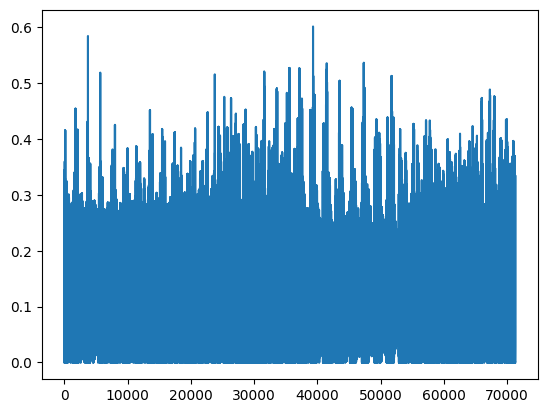

In [25]:
img = color.rgb2gray(data.chelsea())
fd = feature.hog(img, orientations=9, pixels_per_cell=(8, 8),  cells_per_block=(2, 2))
plt.plot(fd)

<p>
Utilize um classificador SVM com os dígitos manuscritos da base de dados MNIST. Para isso, extraia e gere o vetor de características HoG para cada uma das imagens. Este processo deve ser realizado tanto para o conjunto de treinamento quanto para o de teste. Registre cada um dos descritores em uma matriz. Usando os seguintes parâmetros no descritor <i>HoG (orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2))</i>, será gerado um descritor de 144 elementos para uma imagem de 28x28 pixels.</p>

<p>
A função <i>feature_extraction(dataset)</i> será utilizada para extrair o descritor HoG das imagens. Lembre-se de redimensionar a imagem do formato unidimensional de 728 elementos para o formato bidimensional de 28x28 pixels antes de realizar a extração de características.
</p>

In [26]:
def feature_extraction(dataset):
    n = dataset.shape[0]
    hog_X = np.zeros((n, 144))  # cada descritor terá 144 elementos
    for img_num in range(n):
        img = dataset[img_num,:].reshape((28, 28))
        fd = feature.hog(img, orientations=9, pixels_per_cell=(8, 8),  cells_per_block=(2, 2))
        hog_X[img_num, :] = fd
    return hog_X

In [27]:
X_hog_train = feature_extraction(x_img_train)
X_hog_val = feature_extraction(x_img_val)
X_hog_test = feature_extraction(x_img_test)

### Normalizar os dados usando a normalização por padronização

In [29]:
std_scaler = preprocessing.StandardScaler().fit(X_hog_train)
Xn_hog_train = std_scaler.fit_transform(X_hog_train)
Xn_hog_val = std_scaler.transform(X_hog_val)
Xn_hog_test = std_scaler.transform(X_hog_test)

In [30]:
clf_svm = svm.SVC(kernel='linear', C=5)
clf_svm.fit(Xn_hog_train, y_train)
pred_val = clf_svm.predict(Xn_hog_val)
pred_test = clf_svm.predict(Xn_hog_test)

### Matriz de confusão da validação

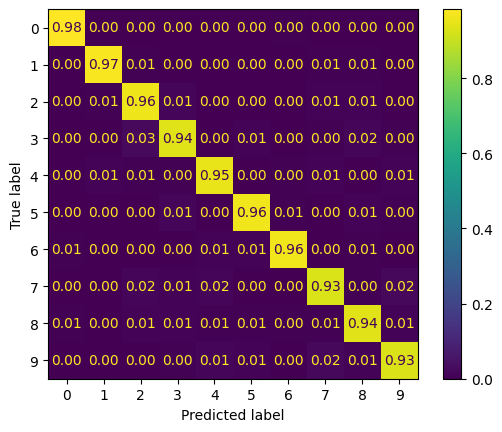

In [31]:
m = metrics.confusion_matrix(y_val, pred_val)
tot = np.sum(m, axis=1, keepdims=True)
np.set_printoptions(precision=2)
m_porc = m/tot
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=m_porc, display_labels=[0,1,2,3,4,5,6,7,8,9])
disp.plot(values_format='.2f')
plt.show()

### Matriz de confusão do teste

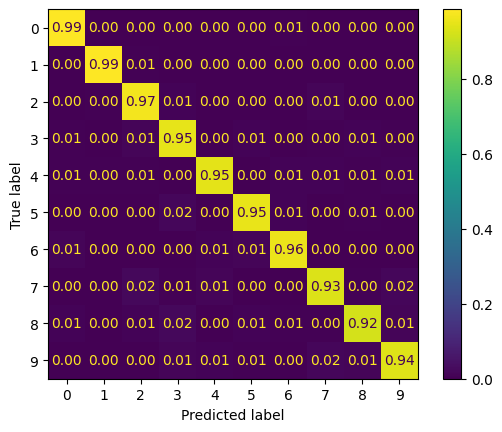

In [34]:
m = metrics.confusion_matrix(y_img_test, pred_test)
tot = np.sum(m, axis=1, keepdims=True)
np.set_printoptions(precision=2)
m_porc = m/tot
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=m_porc, display_labels=[0,1,2,3,4,5,6,7,8,9])
disp.plot(values_format='.2f')
plt.show()